# XGBoost for PLT Reduction Prediction

## Task
- Binary classification
- Target: PLT reduction (0 = normal, 1 = reduced)

## Model
- XGBoost Classifier (xgboost)

## Metrics
- Accuracy
- Precision
- Recall
- F1-score
- ROC-AUC
- PR-AUC

## Notes
This notebook serves as the comparison model.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, StratifiedKFold, LeaveOneOut
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)

plt.rcParams["figure.dpi"] = 120
sns.set_style("whitegrid")

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

TARGET_COL = "PLT 减少事件分组"
DATA_PATH = "../data/PLTdataset.xlsx"
SHEET_NAME = "血小板减少预测"

In [ ]:
df = pd.read_excel(DATA_PATH, sheet_name=SHEET_NAME)

print("Data shape:", df.shape)
df.head()

Data shape: (63, 36)


,样本名称,"PLT count(0,>100,1,<100)",PLT 减少事件分组,PLT 严重程度分组,Gender（女，0；男，1）,动脉血栓（有1，无0）,"FHb(1,>40mg/L;0,<40mg/L)","FHb(1,>40mg/L;0,<40mg/L).1",LDH,"RDW1(0<15%,1≥15%",...,WBC,NC,STO,FIB,D dimer,NO,CHO,LDL,Pla(脂蛋白a),SOD
0,N1,135.0,0.0,0.0,0.0,0.0,19.974734,0.0,237.0,13.7,...,5.90,3.14,25.2,2.13,8.26,28.5,4.28,1.88,0.55,72.0
1,N10,143.0,0.0,0.0,1.0,1.0,20.367691,0.0,273.0,15.0,...,5.50,3.50,18.0,2.30,0.39,49.0,3.17,1.39,0.10,45.0
2,N11,116.0,0.0,0.0,1.0,1.0,49.988801,1.0,167.0,15.2,...,10.21,7.12,5.0,2.38,25.17,34.5,3.70,2.24,0.10,101.0
3,N12,156.0,0.0,0.0,1.0,0.0,14.744621,0.0,216.0,15.0,...,4.21,2.98,5.0,2.30,0.66,30.0,7.82,3.94,0.31,90.0
4,N13,138.0,0.0,0.0,1.0,0.0,15.565815,0.0,125.0,14.7,...,6.90,4.76,5.0,2.42,0.73,35.5,3.48,1.66,0.15,133.0


In [ ]:
df.info()

df[TARGET_COL].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 36 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   样本名称                                       62 non-null     object 
 1   PLT count(0,>100,1,<100)                   62 non-null     float64
 2   PLT 减少事件分组                                 62 non-null     float64
 3   PLT 严重程度分组                                 62 non-null     float64
 4   Gender（女，0；男，1）                            62 non-null     float64
 5   动脉血栓（有1，无0）                                62 non-null     float64
 6   FHb(1,>40mg/L;0,<40mg/L)                   62 non-null     float64
 7   FHb(1,>40mg/L;0,<40mg/L).1                 62 non-null     float64
 8   LDH                                        62 non-null     float64
 9   RDW1(0<15%,1≥15%                           62 non-null     float64
 10  RDW1(0<15%,1≥15%.1          

PLT 减少事件分组
0.0    0.516129
1.0    0.483871
Name: proportion, dtype: float64

In [ ]:
DROP_COLS = ["样本名称", "PLT count(0,>100,1,<100)", "PLT 严重程度分组", "Gender（女，0；男，1）", "动脉血栓（有1，无0）", "FHb(1,>40mg/L;0,<40mg/L).1", "TM(>5450,1;≤5450，0，正常范围5450±2140)pg/mL).1", "PLA2（0<659IU/L,1≥659IU/L）.1", " HGB（1<100mg/L,2≥100mg/L）", "MCV(0<100fL,1≥100mfL).1", "RDW1(0<15%,1≥15%.1", "HDL（0≥0.8mmol/L,1<0.8mmol/L）.1", "FVIII(0.<120;1,>120%).1", TARGET_COL]
X = df.drop(columns=DROP_COLS)
y = df[TARGET_COL]

In [ ]:
print("Missing values:")
print(X.isna().sum().sort_values(ascending=False))

X = X.dropna()
y = y.loc[X.index]

X = pd.get_dummies(X, drop_first=True)
X = X.astype(float)
print("Feature shape after encoding:", X.shape)

Missing values:
FHb(1,>40mg/L;0,<40mg/L)                   1
LDH                                        1
Pla(脂蛋白a)                                  1
LDL                                        1
CHO                                        1
NO                                         1
D dimer                                    1
FIB                                        1
STO                                        1
NC                                         1
WBC                                        1
Age                                        1
FVIII(0.<120;1,>120%)                      1
HDL（0≥0.8mmol/L,1<0.8mmol/L）               1
 HGB（1<100mg/L,0≥100mg/L）                  1
PLA2（0<659IU/L,1≥659IU/L）                  1
脾大（1,是，0否）                                 1
CRP                                        1
TM(>5450,1;≤5450，0，正常范围5450±2140)pg/mL)    1
RDW1(0<15%,1≥15%                           1
SOD                                        1
MCV(0<100fL,1≥100mfL)                  

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X,
#     y,
#     test_size=TEST_SIZE,
#     random_state=RANDOM_STATE,
#     stratify=y
# )

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# print("Train:", X_train.shape)
# print("Test:", X_test.shape)

In [ ]:
# model = XGBClassifier(
#     n_estimators=200,
#     max_depth=3,
#     learning_rate=0.05,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     eval_metric="logloss",
#     random_state=RANDOM_STATE
# )

In [ ]:
# model.fit(X_train, y_train)

xgb_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('xgb', XGBClassifier(
        eval_metric="logloss", 
        use_label_encoder=False, 
        random_state=42
    ))
])

param_grid_xgb = {
    'xgb__max_depth': [1, 2, 3],       # 小样本树要浅
    'xgb__n_estimators': [5, 10, 20, 50], # 树的数量
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__reg_alpha': [0, 0.1, 1],     # L1 正则化抗过拟合
    'xgb__subsample': [0.8, 1.0]       # 每次训练随机抽样比例
}

cv_5fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=param_grid_xgb,
    cv=cv_5fold,
    scoring='f1',
    n_jobs=1
)
grid_search.fit(X, y)
model = grid_search.best_estimator_
print("5-Fold 最佳 F1:", grid_search.best_score_)
print("5-Fold 最佳参数:", grid_search.best_params_)

/root/miniconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:12:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/root/miniconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:12:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/root/miniconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:12:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/root/miniconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:12:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/root/miniconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:12:22] WARNING: /workspace/src/learner.cc:740: 
P

5-Fold 最佳 F1: 0.951048951048951
5-Fold 最佳参数: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 1, 'xgb__n_estimators': 50, 'xgb__reg_alpha': 0, 'xgb__subsample': 0.8}


/root/miniconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:12:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/root/miniconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:12:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/root/miniconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:12:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/root/miniconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:12:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/root/miniconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:12:39] WARNING: /workspace/src/learner.cc:740: 
P

In [ ]:
# y_pred = model.predict(X_test)
# y_prob = model.predict_proba(X_test)[:, 1]

loo = LeaveOneOut()
y_probas_loo = cross_val_predict(model, X, y, cv=loo, method='predict_proba')[:, 1]
y_preds_loo = (y_probas_loo > 0.5).astype(int)

/root/miniconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:12:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/root/miniconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:12:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/root/miniconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:12:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/root/miniconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:12:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/root/miniconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:12:40] WARNING: /workspace/src/learner.cc:740: 
P

In [ ]:
metrics = {
    "accuracy": accuracy_score(y, y_preds_loo),
    "precision": precision_score(y, y_preds_loo),
    "recall": recall_score(y, y_preds_loo),
    "f1": f1_score(y, y_preds_loo),
    "roc_auc": roc_auc_score(y, y_probas_loo),
    "pr_auc": average_precision_score(y, y_probas_loo)
}

metrics_df = pd.DataFrame(metrics, index=["XGBoost"])
metrics_df

,accuracy,precision,recall,f1,roc_auc,pr_auc
XGBoost,0.935484,0.933333,0.933333,0.933333,0.991667,0.991245


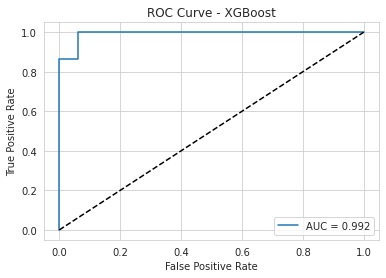

In [ ]:
fpr, tpr, _ = roc_curve(y, y_probas_loo)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {metrics['roc_auc']:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.show()

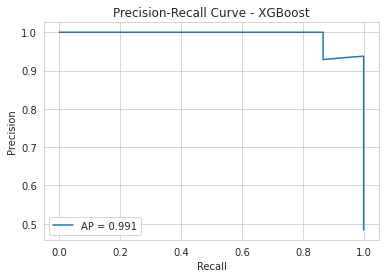

In [ ]:
precision, recall, _ = precision_recall_curve(y, y_probas_loo)

plt.figure()
plt.plot(recall, precision, label=f"AP = {metrics['pr_auc']:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - XGBoost")
plt.legend()
plt.show()

/tmp/ipykernel_882/4293363419.py:24: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_882/4293363419.py:24: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
/root/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


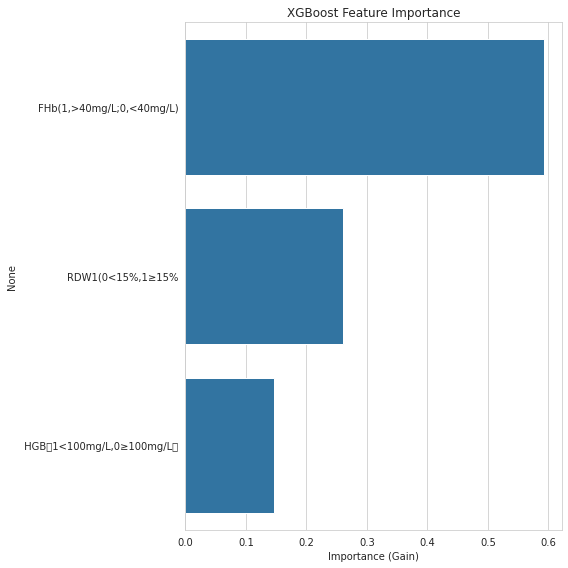


Top 10 Important Features:
FHb(1,>40mg/L;0,<40mg/L)     0.592248
RDW1(0<15%,1≥15%             0.260513
 HGB（1<100mg/L,0≥100mg/L）    0.147239
WBC                          0.000000
Pla(脂蛋白a)                    0.000000
LDL                          0.000000
CHO                          0.000000
NO                           0.000000
D dimer                      0.000000
FIB                          0.000000
dtype: float32


In [ ]:
# XGBoost 是树模型，没有 coef_，要用 feature_importances_
# 从 Pipeline 中提取 XGBoost 模型步骤
xgb_step = model.named_steps['xgb']

# 获取特征重要性
importances = xgb_step.feature_importances_
feature_names = X.columns # 因为没有用 SelectKBest，所以直接用 X.columns

feat_imp = pd.Series(
    importances,
    index=feature_names
).sort_values(ascending=False)

# 绘图
plt.figure(figsize=(8, 8))
# 只画出有重要性的特征 (值 > 0)
top_features = feat_imp[feat_imp > 0].head(20)
if len(top_features) == 0:
    top_features = feat_imp.head(10) # 防止所有都为0的情况

sns.barplot(x=top_features.values, y=top_features.index)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance (Gain)")
plt.tight_layout()
plt.show()

print("\nTop 10 Important Features:")
print(feat_imp.head(10))

# feat_imp = pd.Series(
#     model.feature_importances_,
#     index=X.columns
# ).sort_values(ascending=False)

# plt.figure(figsize=(6, 8))
# sns.barplot(x=feat_imp.head(20), y=feat_imp.head(20).index)
# plt.title("Top 20 Feature Importances (XGBoost)")
# plt.xlabel("Importance")
# plt.tight_layout()
# plt.show()

In [ ]:
metrics_df.to_csv("../outputs/xgb_metrics.csv")
feat_imp.to_csv("../outputs/xgb_feature_importance.csv")

plt.savefig("../outputs/xgb_feature_importance.png", dpi=300)

<Figure size 432x288 with 0 Axes>

## Summary

- Random Forest baseline completed
- PR-AUC suggests model performance under class imbalance
- Top features identified for further analysis

Next steps:
- XGBoost
- LightGBM
- Threshold tuning